# Module A для табличных данных

### Загрузка CSV

In [52]:
import pandas as pd

def load_csv(file_path, chunksize=None):
    """
    Загружает CSV файл.
    Если chunksize указан, возвращает генератор DataFrame для ленивой загрузки.
    """
    if chunksize:
        return pd.read_csv(file_path, chunksize=chunksize)
    else:
        return pd.read_csv(file_path)

# Пример:
# df = load_csv("data.csv")
# для больших файлов (возвращает список из DataFrame'ов): 
df_iter = load_csv("data.csv", chunksize=1000)

[i for i in df_iter][0].shape

(1000, 3)


### Загрузка Excel

In [53]:
import pandas as pd

def load_excel(file_path, sheet_name=0):
    """
    Загружает Excel файл (xls/xlsx).
    sheet_name=0 загружает первый лист, можно указать название листа.
    """
    return pd.read_excel(file_path, sheet_name=sheet_name)

# Пример:
df = load_excel("excel_file.xlsx")
df.sample(2)

,Unnamed: 0.1,Unnamed: 0,file_name,prediction
728,728,728,50728,5
967,967,967,50967,9


### Загрузка TXT (как таблицу, разделитель по табуляции или другой)

In [54]:
import pandas as pd

def load_txt(file_path, sep=',', chunksize=None):
    """
    Загружает TXT файл как таблицу.
    sep — разделитель (по умолчанию табуляция).
    chunksize — для ленивой загрузки больших файлов.
    """
    if chunksize:
        return pd.read_csv(file_path, sep=sep, chunksize=chunksize)
    else:
        return pd.read_csv(file_path, sep=sep)

# Пример:
df = load_txt("data.txt")
# для больших файлов: df_iter = load_txt("data.txt", chunksize=10000)
df.sample(3)

,Unnamed: 0,file_name,prediction
1,1,50001,8
0,0,50000,3
21,21,50021,7


### Загрузка Parquet

In [55]:
import pandas as pd

def load_parquet(file_path):
    """
    Загружает Parquet файл.
    """
    return pd.read_parquet(file_path)

# Пример:
df = load_parquet("data.parquet")
df.sample(3)

,TOP2,TOP3,TOP4,NXTOP2,NXTOP3,NXTOP4,N2XTOP2,N2XTOP3,N2XTOP4,LONGITUDE,...,SAT,SAT2,NXSAT,SATXT2,SATXT3,SATXT4,SAT2XT2,SAT2XT3,SAT2XT4,geometry
1492,1,0,0,0,0,0,0,0,0,-63.844610,...,2.15,4.62,0.000000,2.15,0.0,0.00,4.62,0.0,0.00,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
1267,0,0,1,0,0,66,0,0,4356,-63.847047,...,2.21,4.88,145.860001,0.00,0.0,2.21,0.00,0.0,4.88,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
1064,0,0,1,0,0,29,0,0,841,-63.847714,...,2.18,4.75,63.220001,0.00,0.0,2.18,0.00,0.0,4.75,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...


### Загрузка бинарных файлов

In [56]:
import struct
import numpy as np

def load_bin_image(path):
    """
    Загружает бинарный файл с изображением в numpy.ndarray
    Формат:
    - magic (4 байта)
    - array_length (uint32)
    - version (uint8)
    - data_type_code (uint8)
    - reserved (2 байта)
    - data (array_length * dtype)
    """
    with open(path, 'rb') as file:
        # Заголовок
        magic = file.read(4)
        array_length = struct.unpack('<I', file.read(4))[0]
        version = struct.unpack('<B', file.read(1))[0]
        data_type_code = struct.unpack('<B', file.read(1))[0]
        reserved = file.read(2)

        # Таблица типов данных
        data_types = {
            0: np.uint8,
            1: np.float32,
            2: np.int32
        }

        if data_type_code not in data_types:
            raise ValueError(f"Неизвестный data_type_code: {data_type_code}")

        dtype = data_types[data_type_code]
        element_size = np.dtype(dtype).itemsize

        # Чтение данных (без лишних копий)
        raw = file.read(array_length * element_size)
        data = np.frombuffer(raw, dtype=dtype)

        # Восстановление формы (квадратное изображение)
        side = int(array_length ** 0.5)
        image = data.reshape((side, side))

    return image

In [57]:
load_bin_image('data.mybin').shape

(28, 28)

При работе с бинарным файлом любого типа (изображение, таблица, аудио, временной ряд и т.д.) в первую очередь необходимо строго определить и описать его формат: структуру заголовка (сигнатура, версия, размеры, тип данных, служебные байты), порядок байтов (endianness) и способ хранения данных; затем файл следует читать последовательно в бинарном режиме (rb), извлекая метаданные через struct.unpack, после чего основные данные загружать в подходящую структуру без лишних копий (например, numpy.frombuffer или numpy.memmap при ограниченной оперативной памяти), приводя их к нужной форме (shape) и типу (dtype), а уже на этом уровне интерпретировать содержимое как изображение, таблицу (DataFrame), аудиосигнал или другой объект для дальнейшего анализа, визуализации или обучения моделей.

### Загрузка изображений (PIL)

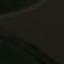

In [58]:
from PIL import Image
import os
import glob

def load_images(folder_path, extensions=None):
    """
    Загружает изображения из папки как PIL.Image
    """
    
    images = []
    for path in os.listdir(folder_path):
        img = Image.open(folder_path + path)
        images.append(img)
    
    return images

# Пример:
images = load_images("images/")
images[3]

Если файлов очень много — лучше хранить пути, а не сами изображения.

### Загрузка аудио

In [59]:
import librosa
import os
import glob

def load_audio(folder_path):
    """
    Загружает аудиофайлы с помощью librosa
    """

    audio_data = []
    for path in os.listdir(folder_path):
        y, sr = librosa.load(folder_path + path)
        audio_data.append({
            "path": path,
            "signal": y,
            "sr": sr
        })
    
    return audio_data

# Пример:
audios = load_audio("audio/")
audios[2]

{'path': '4.ogg',
 'signal': array([-0.01645593, -0.00119762,  0.00812328, ..., -0.00090311,
         0.00022031, -0.02933456], shape=(220500,), dtype=float32),
 'sr': 22050}

### Загрузка видео

In [60]:
import cv2
import os
import glob

def load_videos(folder_path):
    """
    Загружает видео как cv2.VideoCapture (ленивое чтение)
    """
    
    videos = []
    for path in os.listdir(folder_path):
        cap = cv2.VideoCapture(folder_path + path)
        videos.append({
            "path": path,
            "capture": cap
        })
    
    return videos


videos = load_videos('videos/')
videos[1]

{'path': 'barbell biceps curl_12.mp4',
 'capture': < cv2.VideoCapture 0000025684D25A10>}

Работа с видео сводится к обработке каждого кадра, также как к изображениям.

In [61]:
videos[1]['capture'].read()

(True,
 array([[[51, 41, 22],
         [51, 41, 22],
         [51, 41, 22],
         ...,
         [16, 11, 10],
         [16, 11, 10],
         [16, 11, 10]],
 
        [[51, 41, 22],
         [51, 41, 22],
         [51, 41, 22],
         ...,
         [16, 11, 10],
         [16, 11, 10],
         [16, 11, 10]],
 
        [[51, 41, 22],
         [51, 41, 22],
         [51, 41, 22],
         ...,
         [16, 11, 10],
         [16, 11, 10],
         [16, 11, 10]],
 
        ...,
 
        [[42, 33, 25],
         [42, 33, 25],
         [42, 33, 25],
         ...,
         [29, 28, 22],
         [28, 27, 21],
         [28, 27, 21]],
 
        [[41, 32, 24],
         [41, 32, 24],
         [42, 33, 25],
         ...,
         [29, 28, 22],
         [28, 27, 21],
         [28, 27, 21]],
 
        [[41, 32, 24],
         [41, 32, 24],
         [42, 33, 25],
         ...,
         [29, 28, 22],
         [29, 28, 22],
         [29, 28, 22]]], shape=(1080, 1920, 3), dtype=uint8))